<a href="https://colab.research.google.com/github/elangbijak4/Causality-Base-PCA/blob/main/Demo1_Quantum_Causality_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Toy QCM (scalar causal weights) ===


,X0,X1,X2,X3,X4,X5
X0,0.610463,-0.036901,-0.292930,0.890275,0.835339,-0.136359
X1,-0.036901,2.995517,0.256103,0.700109,-0.507176,-0.124304
X2,-0.292930,0.256103,1.108866,-0.386009,-0.297115,-0.067667
X3,0.890275,0.700109,-0.386009,2.163257,0.719872,-0.805326
X4,0.835339,-0.507176,-0.297115,0.719872,1.567852,0.505497
X5,-0.136359,-0.124304,-0.067667,-0.805326,0.505497,1.657106



Top eigenvalues (QC-PCA surrogate):
[3.659068 3.211145 1.983347 0.958008 0.291493]


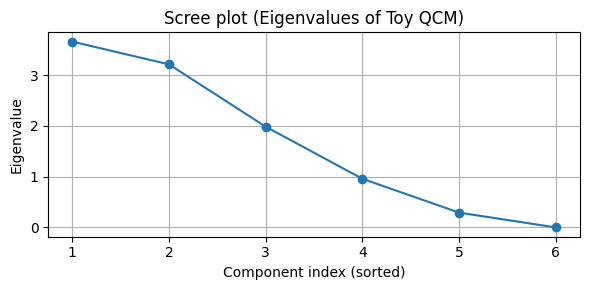


=== 2D embedding of features (QC-PCA surrogate) ===


,PC1,PC2
X0,0.450742,0.608933
X1,1.211478,-1.081174
X2,-0.131650,-0.478140
X3,1.270489,0.626218
X4,0.206842,1.023122
X5,-0.560323,0.062154


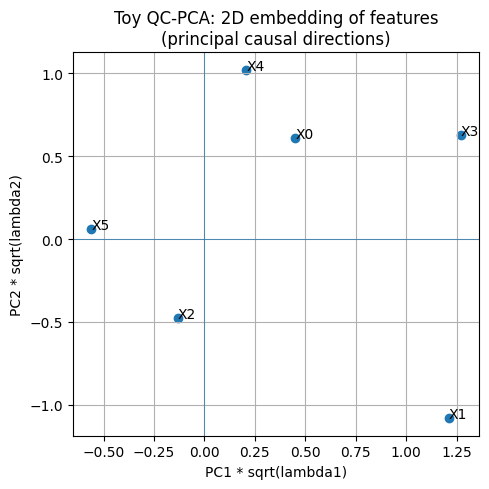

In [5]:
# Toy hybrid implementation for QC-PCA-like pipeline (tanpa ace_tools)
# ---------------------------------------------------------------
# - Membuat "embedding kuantum" sederhana untuk setiap fitur
# - Membangun process matrix Hermitian acak untuk tiap pasangan fitur
# - Menghitung operator kausal C_{i->j}
# - Menyimetrisasi menjadi H_{ij} lalu mengontraksi ke skalar untuk QCM
# - QC-PCA surrogate: eigen-decomposition QCM + embedding 2D

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd

from math import sqrt
from IPython.display import display  # untuk tampilkan DataFrame di Colab

np.random.seed(42)

def rand_pure_state(dim=2):
    """Random pure state |psi><psi| di C^dim."""
    v = (np.random.randn(dim) + 1j * np.random.randn(dim))
    v = v / la.norm(v)
    rho = np.outer(v, np.conjugate(v))
    return rho, v

def random_hermitian(n):
    """Hermitian acak n x n."""
    A = np.random.randn(n, n) + 1j * np.random.randn(n, n)
    H = (A + A.conj().T) / 2
    return H

def partial_trace_left(mat, dimA=2, dimB=2):
    """
    Tr_A[mat] untuk mat yang hidup di ruang A ⊗ B.
    mat shape: (dimA*dimB, dimA*dimB)
    return: (dimB, dimB)
    """
    mat = mat.reshape((dimA, dimB, dimA, dimB))
    # trace over index A (0 dan 2)
    res = np.einsum('i j i k -> j k', mat)
    return res

# ----------------- Parameter toy -----------------
d = 6      # jumlah fitur
dim = 2    # dimensi tiap fitur (anggap qubit)

# 1) Buat embedding kuantum random untuk tiap fitur
rhos = []
kets = []
for i in range(d):
    rho, ket = rand_pure_state(dim)
    rhos.append(rho)
    kets.append(ket)

# 2) Bangun process matrix Hermitian acak W_ij untuk tiap pasangan
W = {}
for i in range(d):
    for j in range(d):
        W[(i, j)] = random_hermitian(dim * dim)  # 4x4 untuk dua qubit

# 3) Hitung operator kausal C_{i->j} dan H_ij
H_ops = [[None] * d for _ in range(d)]
for i in range(d):
    for j in range(d):
        rho_i = rhos[i]
        rho_j = rhos[j]

        # C_{i->j} = Tr_i[ W_ij (rho_i ⊗ I_j) ]
        I_j = np.eye(dim)
        kron_ij = np.kron(rho_i, I_j)
        mat_ij = W[(i, j)] @ kron_ij
        C_i_j = partial_trace_left(mat_ij, dimA=dim, dimB=dim)

        # C_{j->i} = Tr_j[ W_ji (rho_j ⊗ I_i) ]
        I_i = np.eye(dim)
        kron_ji = np.kron(rho_j, I_i)
        mat_ji = W[(j, i)] @ kron_ji
        C_j_i = partial_trace_left(mat_ji, dimA=dim, dimB=dim)

        # H_ij = 1/2 ( C_{i->j} + C_{j->i}^\dagger )
        H = 0.5 * (C_i_j + C_j_i.conj().T)
        # paksa Hermitian secara numerik
        H = 0.5 * (H + H.conj().T)
        H_ops[i][j] = H

# 4) Kontraksi ke skalar: h_ij = Re( Tr[ H_ij * rho_j ] )
QCM = np.zeros((d, d), dtype=float)
for i in range(d):
    for j in range(d):
        h = np.trace(H_ops[i][j] @ rhos[j])
        QCM[i, j] = np.real(h)

# Simetrisasi & regularisasi agar PSD
QCM = 0.5 * (QCM + QCM.T)
eigvals = la.eigvalsh(QCM)
min_ev = np.min(eigvals)
if min_ev < 1e-8:
    QCM = QCM + (abs(min_ev) + 1e-8) * np.eye(d)

# 5) Tampilkan QCM sebagai DataFrame
df_qcm = pd.DataFrame(
    np.round(QCM, 6),
    columns=[f'X{idx}' for idx in range(d)],
    index=[f'X{idx}' for idx in range(d)]
)

print("=== Toy QCM (scalar causal weights) ===")
display(df_qcm)

# 6) Eigen-decomposition (QC-PCA surrogate)
vals, vecs = la.eigh(QCM)   # ascending
idx = np.argsort(vals)[::-1]   # descending
vals = vals[idx]
vecs = vecs[:, idx]

print("\nTop eigenvalues (QC-PCA surrogate):")
print(np.round(vals[:min(5, len(vals))], 6))

# Scree plot
plt.figure(figsize=(6, 3))
plt.plot(np.arange(1, d + 1), vals, marker='o')
plt.title("Scree plot (Eigenvalues of Toy QCM)")
plt.xlabel("Component index (sorted)")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7) Embedding 2D menggunakan dua eigenvector utama
r = 2
U_r = vecs[:, :r]          # d x 2
Lambda_r = vals[:r]        # panjang 2
coords = U_r * np.sqrt(Lambda_r[np.newaxis, :])  # d x 2

df_coords = pd.DataFrame(
    np.round(coords, 6),
    columns=[f'PC{k+1}' for k in range(r)],
    index=[f'X{idx}' for idx in range(d)]
)

print("\n=== 2D embedding of features (QC-PCA surrogate) ===")
display(df_coords)

plt.figure(figsize=(5, 5))
plt.scatter(coords[:, 0], coords[:, 1])
for i, txt in enumerate(df_coords.index):
    plt.annotate(txt, (coords[i, 0], coords[i, 1]))
plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.title("Toy QC-PCA: 2D embedding of features\n(principal causal directions)")
plt.xlabel("PC1 * sqrt(lambda1)")
plt.ylabel("PC2 * sqrt(lambda2)")
plt.grid(True)
plt.tight_layout()
plt.show()
